# Process data from the IMU testing rig

The IMU testing rig was an arm that could swivel and move forward and back.  There was an IMU mounted on the end of the arm, and another on the base, and an encoder on the swivel.

Here, we test how well the IMU on the end can recover the angle of the arm from the encoder and how well it can match the forward-back acceleration measured by the IMU on the base.

![Testing Rig](/Users/etytel01/Documents/Acceleration/rawdata/data_2017_07_28/static_straight_up.jpg Testing)

### Setup

Import the various libraries that we need.

In [1]:
import numpy as np
import h5py

import matplotlib.pyplot as plt


from matplotlib import gridspec
import seaborn as sns
sns.set_context('notebook', font_scale=1.0)

%matplotlib inline

And import the functions from the imucapture package.

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from imucapture.data import Data
from imucapture.calib import Calib
from imucapture.transform import Transform, eul2rotm

## Load the data

### Calibration data

In [4]:
calibfilename = '/Users/etytel01/Documents/Acceleration/rawdata/data_2017_07_28/calib.hdf5'

In [5]:
calibdata = Data.from_file_smart(calibfilename)

ERROR:root:unknown dataset type: unknownassuming raw data


In the calibration data set, we have both IMUs, but we only have a real calibration for the first one.  The one on the base doesn't move, and so we can't get multiple axes.  So we'll just work with the first one.

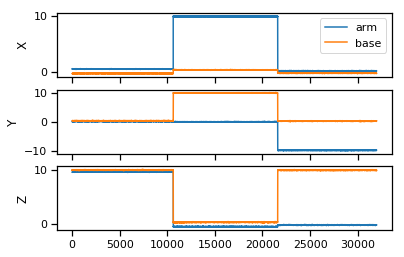

In [8]:
fig, ax = plt.subplots(3, 1, sharex=True)

for acc1, ax1 in zip(calibdata.get_acceleration(0), ax):
    ax1.plot(calibdata.timestamps, acc1, label='arm')
    
for acc1, ax1 in zip(calibdata.get_acceleration(1), ax):
    ax1.plot(calibdata.timestamps, acc1, label='base')
    
ax[0].set_ylabel('X')
ax[1].set_ylabel('Y')
ax[2].set_ylabel('Z')
ax[0].legend()

plt.show()

In [9]:
calibdata1 = calibdata.get_one_imu(0)

calib = Calib()
calib.parse_data(calibdata1)

True

Check the basis matrix.

In [10]:
world_basis = calib.imu_bases[0]

world_basis

array([[ 0.04575447,  0.9988925 ,  0.01096806],
       [ 0.01030906,  0.01050683, -0.99989166],
       [-0.99889952,  0.04586259, -0.00981691]])

Rows (CHECK) in the world basis represent the world's axes in IMU coordinates.  Here, the world's X axis (forward and back) is mostly along the chip's -Z axis.  The world's Y axis (side to side) is mostly the chip's X axis.  And the world's Z axis (up and down) is mostly the chip's Y axis.

This makes sense based on the picture of the rig.

In [65]:
base_basis = np.array([[1.0, 0.0, 0.0],
                       [0.0, 1.0, 0.0],
                       [0.0, 0.0, 1.0]])

The IMU on the base is aligned with the world coordinates, so its basis is just the identity matrix.

## Rotation only data

In this data set, the arm only rotates back and forth.

In [11]:
datafilename = '/Users/etytel01/Documents/Acceleration/rawdata/data_2017_07_28/rotate_only.hdf5'

data = Data.from_file_smart(datafilename, resample=True)

ERROR:root:unknown dataset type: unknownassuming raw data


In [50]:
t = data.timestamps / 1000.0        # convert from milliseconds
dt = t[1] - t[0]

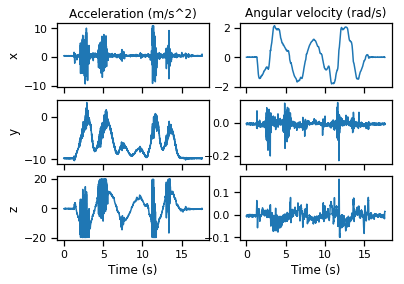

In [13]:
fig, ax = plt.subplots(3, 2, sharex=True)

for i, (acc1, gyro1, lab1) in enumerate(zip(data.get_acceleration(), data.get_gyroscope(), 
                                            ['x','y','z'])):
    ax[i, 0].plot(t, acc1)
    ax[i, 0].set_ylabel(lab1)
    
    ax[i, 1].plot(t, gyro1)

ax[0, 0].set_title('Acceleration (m/s^2)')
ax[0, 1].set_title('Angular velocity (rad/s)')

ax[-1, 0].set_xlabel('Time (s)')
ax[-1, 1].set_xlabel('Time (s)')

plt.show()

Raw acceleration and angular velocity data.

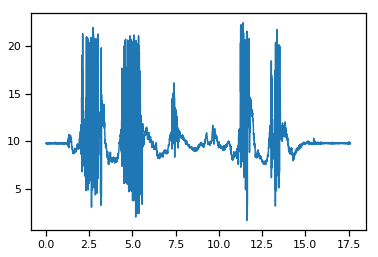

In [14]:
mag = np.linalg.norm(data.get_acceleration(), axis=0)

plt.plot(t, mag)

Process the data using the DSF and Madgwick algorithms

In [15]:
accdyn_dsf, orient_dsf = Transform().get_orientation_dsf(data, calib, imu=0, filter_num_samples=10, accdynmag=200.0,
                                                         initial_window=0.5)

(3, 3520)
(3, 3520)


In [16]:
accdyn_mad, orient_mad = Transform().get_orientation_madgwick(data, calib, imu=0, filter_num_samples=10,
                                                              beta=np.deg2rad(2.86))

Get the true orientation from the encoder

In [22]:
with h5py.File(datafilename) as h5file:
    orient_y0 = np.deg2rad(np.array(h5file['/data/Encoder']))
    t_enc = np.array(h5file['/data/time'])

The encoder starts at an arbitrary value, so we subtract off the initial value.  Also it seems to advance in the opposite direction as the orientation algorithms, so we flip the sign.

In [23]:
orient_y0 = -(orient_y0 - orient_y0[0])

Now interpolate onto the same timebase as the IMU data and filter

In [24]:
# interpolate onto the same timebase as the IMU data
orient_y = np.interp(data.timestamps, t_enc, orient_y0)

# filter with a running average
orient_y = np.convolve(orient_y, np.ones((80,))/80, mode='same')

orient_true = np.zeros_like(orient_dsf)
orient_true[1, :] = orient_y

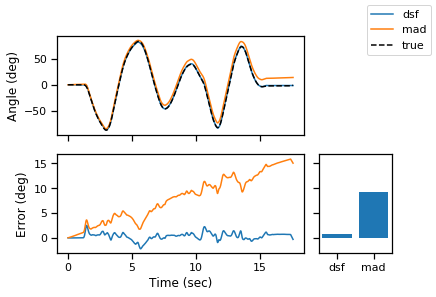

In [38]:
fig = plt.figure()
gs = gridspec.GridSpec(2, 4)

ax1 = fig.add_subplot(gs[0, :-1])
ax2 = fig.add_subplot(gs[1, :-1], sharex=ax1)
ax3 = fig.add_subplot(gs[1, -1], sharey=ax2)

ax1.plot(t, np.rad2deg(orient_dsf[1, :]), label='dsf')
ax1.plot(t, np.rad2deg(orient_mad[1, :]), label='mad')
ax1.plot(t, np.rad2deg(orient_true[1, :]), 'k--', label='true')

ax1.set_ylabel('Angle (deg)')
fig.legend()
plt.setp(ax1.get_xticklabels(), visible=False)

err = np.array([np.rad2deg(orient_dsf[1, :] - orient_true[1, :]), np.rad2deg(orient_mad[1, :] - orient_true[1, :])])
rms = np.sqrt(np.mean(np.square(err), axis=1))

ax2.plot(t, err[0, :], label='dsf')
ax2.plot(t, err[1, :], label='mad')

ax2.set_ylabel('Error (deg)')
ax2.set_xlabel('Time (sec)')

ax3.bar([1, 2], rms)
# ax3.boxplot(err.T)
ax3.set_xticks([1, 2])
ax3.set_xticklabels(['dsf', 'mad'])
plt.setp(ax3.get_yticklabels(), visible=False)

plt.show()

Check the other axes.  Rotation should be zero.

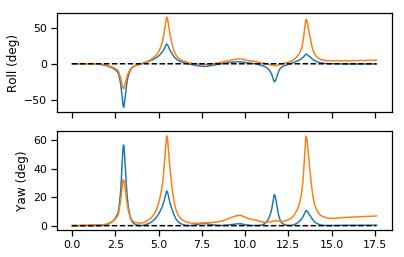

In [48]:
fig, ax = plt.subplots(2, 1, sharex=True)


ax[0].plot(t, np.rad2deg(orient_dsf[0, :]), label='dsf')
ax[0].plot(t, np.rad2deg(orient_mad[0, :]), label='mad')
ax[0].plot(t, np.rad2deg(orient_true[0, :]), 'k--', label='true')
ax[0].set_ylabel('Roll (deg)')

ax[1].plot(t, np.rad2deg(orient_dsf[2, :]), label='dsf')
ax[1].plot(t, np.rad2deg(orient_mad[2, :]), label='mad')
ax[1].plot(t, np.rad2deg(orient_true[2, :]), 'k--', label='true')
ax[1].set_ylabel('Yaw (deg)')

plt.show()

Note that the apparent errors in roll and yaw are due to being close to the Euler angle singularity, not true errors.

### Check the dynamic acceleration estimation

Because the IMU is on the end of the arm, as the arm rotates, it also causes the chip to accelerate.  We can therefore estimate the dynamic acceleration from the encoder and compare that to the estimate from the chip.

In [55]:
omega_world_true = np.gradient(orient_true, dt, axis=1)
omega_dot_world_true = np.gradient(omega_world_true, dt, axis=1)

omega_chip_true = world_basis.dot(omega_world_true)

Compare the angular velocity from the encoder to the chip's measured angular velocities.

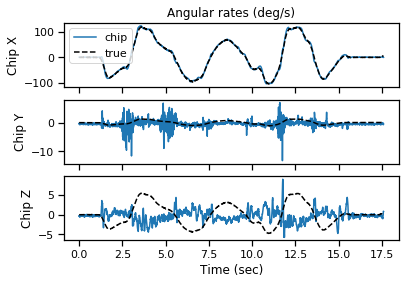

In [56]:
fig, ax = plt.subplots(3, sharex=True)

for omega1, omega_true1, ax1 in zip(data.get_gyroscope(0), omega_chip_true, ax):
    ax1.plot(t, np.rad2deg(omega1), label='chip')
    ax1.plot(t, np.rad2deg(omega_true1), 'k--', label='true')
    
ax[0].set_title('Angular rates (deg/s)')
ax[0].set_ylabel('Chip X')
ax[1].set_ylabel('Chip Y')
ax[2].set_ylabel('Chip Z')

ax[0].legend()
ax[2].set_xlabel('Time (sec)')

plt.show()

Now compute the true dynamic acceleration.  Dynamic acceleration includes the angular component, due to angular acceleration, and the centripetal component, directed outward along the arm, plus the actual dynamic acceleration of the center of mass.

xpb is the position of the chip on the arm, relative to the base

In [64]:
armlen = 0.5    # meters
xpb_world = np.array([0, 0, armlen])
xpb_chip = world_basis.dot(xpb_world)

xpb_chip

array([ 0.00548403, -0.49994583, -0.00490846])

The chip is about 0.5 m displaced along its negative y axis.

In [85]:
acc_base = np.array([base_basis.dot(acc1) - np.array([0, 0, 9.81]) for acc1 in data.get_acceleration(1).T]).T
acc_base = np.array([np.convolve(a1, np.ones((100,))/100, mode='same') for a1 in acc_base])

In [94]:
acc_angular_true = np.cross(omega_dot_world_true.T, xpb_world).T
acc_centrip_true = np.cross(omega_world_true.T, np.cross(omega_world_true.T, xpb_world)).T
accdyn_true = acc_angular_true + acc_centrip_true + acc_base

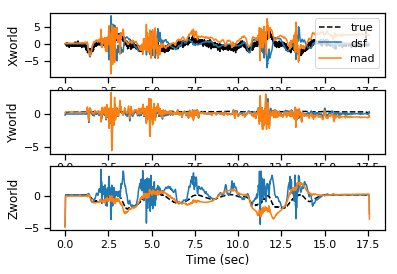

In [96]:
fig, ax = plt.subplots(3)

for acc_dsf1, acc_mad1, acc_true1, ax1 in zip(np.array(accdyn_dsf), accdyn_mad, 
                                              accdyn_true, ax):
    ax1.plot(t, np.array(acc_true1), 'k--', label='true')
    ax1.plot(t, np.array(acc_dsf1), label='dsf')
    ax1.plot(t, np.array(acc_mad1), label='mad')

ax[0].legend(loc='upper right')
ax[0].set_ylabel('Xworld')
ax[1].set_ylabel('Yworld')
ax[2].set_ylabel('Zworld')

ax[2].set_xlabel('Time (sec)')

plt.show()

Compute an acceleration error.  Here we just use the magnitude of the vector difference between the estimated acceleration and the true acceleration.

In [99]:
acc_err_dsf = np.array([np.linalg.norm(acc_true1 - acc_dsf1) for acc_true1, acc_dsf1 in zip(accdyn_true.T, accdyn_dsf.T)])
acc_err_mad = np.array([np.linalg.norm(acc_true1 - acc_mad1) for acc_true1, acc_mad1 in zip(accdyn_true.T, accdyn_mad.T)])

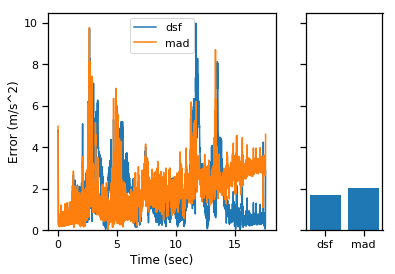

In [110]:
fig, ax = plt.subplots(1, 2, gridspec_kw = {'width_ratios':[3, 1]}, sharey=True)

ax[0].plot(t, acc_err_dsf, label='dsf')
ax[0].plot(t, acc_err_mad, label='mad')
ax[0].legend()
ax[0].set_xlabel('Time (sec)')
ax[0].set_ylabel('Error (m/s^2)')

ax[1].bar([1, 2], [np.mean(acc_err_dsf), np.mean(acc_err_mad)])
ax[1].set_xticks([1, 2])
ax[1].set_xticklabels(['dsf', 'mad'])

plt.show()

If we know the distance of the accelerometer from the true center of mass, we can estimate the dynamic acceleration based on the chip's angular velocity and angular acceleration, just like we did from the arm.  Compare the true dynamic acceleration components to those estimated from the gyro

Get the gyro readings and take the derivative to get angular acceleration.

In [111]:
omega = data.get_gyroscope(0)
omega_dot = np.gradient(omega, dt, axis=1)

In [122]:
acc_angular = world_basis.T.dot(np.cross(omega_dot.T, xpb_chip).T)
acc_centrip = world_basis.T.dot(np.cross(omega.T, np.cross(omega.T, xpb_chip)).T)

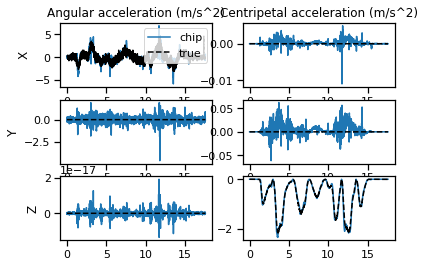

In [124]:
fig, ax = plt.subplots(3,2)

for angular1, centrip1, angular_true1, centrip_true1, ax1 in zip(acc_angular, acc_centrip, 
                                                                 acc_angular_true, acc_centrip_true, ax):
    ax1[0].plot(t, angular1, label='chip')
    ax1[0].plot(t, angular_true1, 'k--', label='true')
    ax1[1].plot(t, centrip1, label='chip')
    ax1[1].plot(t, centrip_true1, 'k--', label='true')

ax[0, 0].set_title('Angular acceleration (m/s^2)')
ax[0, 1].set_title('Centripetal acceleration (m/s^2)')
ax[0, 0].set_ylabel('X')
ax[1, 0].set_ylabel('Y')
ax[2, 0].set_ylabel('Z')
ax[0, 0].legend()

plt.show()

Note that these computational are almost entirely geometry.  We have the gyro readings and we're just using our knowledge that the chip is on the end of the arm to get these values.

## Rotation and translation

In [15]:
datafilename = '/Users/etytel01/Documents/Acceleration/rawdata/data_2017_07_28/rotate_and_translate.hdf5'

data = Data.from_file_smart(datafilename, resample=True)

ERROR:root:unknown dataset type: unknownassuming raw data


In [17]:
t = data.timestamps / 1000.0        # convert from milliseconds

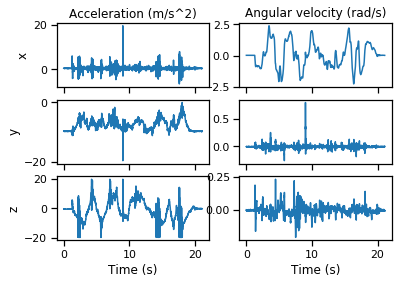

In [18]:
fig, ax = plt.subplots(3, 2, sharex=True)

for i, (acc1, gyro1, lab1) in enumerate(zip(data.get_acceleration(), data.get_gyroscope(), 
                                            ['x','y','z'])):
    ax[i, 0].plot(t, acc1)
    ax[i, 0].set_ylabel(lab1)
    
    ax[i, 1].plot(t, gyro1)

ax[0, 0].set_title('Acceleration (m/s^2)')
ax[0, 1].set_title('Angular velocity (rad/s)')

ax[-1, 0].set_xlabel('Time (s)')
ax[-1, 1].set_xlabel('Time (s)')

plt.show()

In [19]:
accdyn_dsf, orient_dsf = Transform().get_orientation_dsf(data, calib, imu=0, filter_num_samples=10, accdynmag=200.0)
accdyn_mad, orient_mad = Transform().get_orientation_madgwick(data, calib, imu=0, filter_num_samples=10,
                                                              beta=np.deg2rad(2.86))

(3, 4219)
(3, 4219)


In [20]:
with h5py.File(datafilename) as h5file:
    orient_z0 = np.deg2rad(np.array(h5file['/data/Encoder']))
    t_enc = np.array(h5file['/data/time'])

orient_z0 = orient_z0 - orient_z0[0]

# interpolate onto the same timebase as the IMU data
orient_z = np.interp(data.timestamps, t_enc, orient_z0)

# filter with a running average
orient_z = np.convolve(orient_z, np.ones((80,))/80, mode='same')

orient_true = np.zeros_like(orient_dsf)
orient_true[2, :] = orient_z

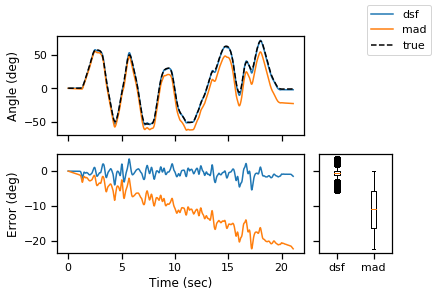

In [21]:
fig = plt.figure()
gs = gridspec.GridSpec(2, 4)

ax1 = fig.add_subplot(gs[0, :-1])
ax2 = fig.add_subplot(gs[1, :-1], sharex=ax1)
ax3 = fig.add_subplot(gs[1, -1], sharey=ax2)

ax1.plot(t, np.rad2deg(orient_dsf[2, :]), label='dsf')
ax1.plot(t, np.rad2deg(orient_mad[2, :]), label='mad')
ax1.plot(t, np.rad2deg(orient_true[2, :]), 'k--', label='true')

ax1.set_ylabel('Angle (deg)')
fig.legend()
plt.setp(ax1.get_xticklabels(), visible=False)

err = np.array([np.rad2deg(orient_dsf[2, :] - orient_true[2, :]), np.rad2deg(orient_mad[2, :] - orient_true[2, :])])
ax2.plot(t, err[0, :], label='dsf')
ax2.plot(t, err[1, :], label='mad')

ax2.set_ylabel('Error (deg)')
ax2.set_xlabel('Time (sec)')

ax3.boxplot(err.T)
ax3.set_xticklabels(['dsf', 'mad'])
plt.setp(ax3.get_yticklabels(), visible=False)

plt.show()

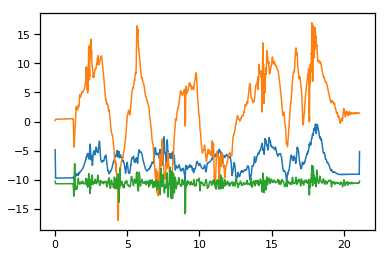

In [23]:
plt.plot(t, accdyn_mad.T)

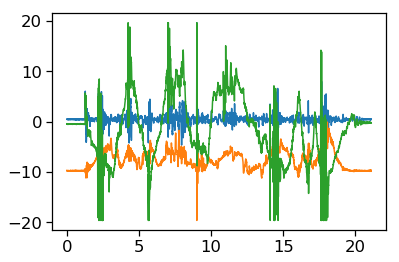

In [68]:
plt.plot(t, data.get_acceleration(0).T)